## Librerias

In [37]:
%matplotlib inline

import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Carga de datos

In [38]:
# --- CONFIGURACIÓN ---
IMG_SIZE = (100, 100)
CLASES_MAP = {
    "joy": 0, "joyful": 0,
    "neutral": 1,
    "distraction": 2, "distracted": 2,
    "fatigue": 3, "fatigued": 3,
    "confusion": 4, "confused": 4
}

# 1. Cargar el detector desde el archivo local
cascade_path = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

# Verificación inmediata
if face_cascade.empty():
    print(f"ERROR: Archivo no encontrado en '{cascade_path}'.")
else:
    print("Detector cargado correctamente desde archivo local.")

def detectar_y_recortar(img):
    """ Detecta rostro, recorta y devuelve. Si falla, devuelve original. """
    if face_cascade.empty(): return img
    
    # Haar funciona mejor en escala de grises
    rostros = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(rostros) > 0:
        # Tomar el rostro más grande (area = w * h)
        x, y, w, h = max(rostros, key=lambda b: b[2] * b[3])
        return img[y:y+h, x:x+w]
    return img

def cargar_datos_fisher_mejorado(ruta_split):
    X = []
    y = []
    print(f"Procesando: {ruta_split}")
    
    if not os.path.exists(ruta_split):
        print(f"La ruta no existe: {ruta_split}")
        return np.array([]), np.array([])

    carpetas_emocion = os.listdir(ruta_split)
    
    for nombre_carpeta in carpetas_emocion:
        nombre_lower = nombre_carpeta.lower()
        if nombre_lower in CLASES_MAP:
            label = CLASES_MAP[nombre_lower]
            ruta_emocion = os.path.join(ruta_split, nombre_carpeta)
            
            # Recorrer archivos
            for archivo in os.listdir(ruta_emocion):
                ruta_img = os.path.join(ruta_emocion, archivo)
                try:
                    # Leer en gris
                    img = cv2.imread(ruta_img, 0)
                    if img is not None:
                        # Detectar -> Recortar -> Resize
                        img_face = detectar_y_recortar(img)
                        img_resized = cv2.resize(img_face, IMG_SIZE)
                        
                        X.append(img_resized.flatten())
                        y.append(label)
                except Exception as e:
                    pass # Ignorar imágenes corruptas

    return np.array(X), np.array(y)

# --- EJECUCIÓN ---
if not face_cascade.empty():
    base_path = "Synthetic_DB_CAS" # Verifica que esta ruta sea correcta
    
    print("--- Recargando TRAIN ---")
    X_train, y_train = cargar_datos_fisher_mejorado(os.path.join(base_path, "train"))
    
    print("--- Recargando VAL ---")
    X_val, y_val = cargar_datos_fisher_mejorado(os.path.join(base_path, "val"))
    
    print("--- Recargando TEST ---")
    X_test, y_test = cargar_datos_fisher_mejorado(os.path.join(base_path, "test"))
    
    print(f"\nDimensiones finales Train: {X_train.shape}")

Detector cargado correctamente desde archivo local.
--- Recargando TRAIN ---
Procesando: Synthetic_DB_CAS\train
--- Recargando VAL ---
Procesando: Synthetic_DB_CAS\val
--- Recargando TEST ---
Procesando: Synthetic_DB_CAS\test

Dimensiones finales Train: (424, 10000)


## Preparación de datos

In [39]:
print("--- Preparando Datos ---")
# Concatenamos las filas (axis=0) de Train y Val
X_full_train = np.concatenate((X_train, X_val), axis=0)
y_full_train = np.concatenate((y_train, y_val), axis=0)

print(f"Set de Entrenamiento Completo (Train+Val): {X_full_train.shape}")
print(f"Set de Prueba (Test): {X_test.shape}")


--- Preparando Datos ---
Set de Entrenamiento Completo (Train+Val): (514, 10000)
Set de Prueba (Test): (92, 10000)


## Estandarizar

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_full_train)
X_test_scaled = scaler.transform(X_test)

## PCA

In [41]:
# Usamos .95 para conservar el 95% de la varianza original y reducir ruido
pca = PCA(n_components=0.95, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensiones tras PCA: {X_train_pca.shape[1]} componentes principales (de 10,000 originales)")


Dimensiones tras PCA: 148 componentes principales (de 10,000 originales)


## LDA

In [42]:
lda = LDA()
lda.fit(X_train_pca, y_full_train)
print("Modelo LDA entrenado exitosamente.")

Modelo LDA entrenado exitosamente.


In [43]:
sns.set_style("whitegrid")
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]

# --- VISUALIZACIÓN 1: Muestras de Entrada ---
def plot_samples(X, y, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i in range(n_samples):
        # Tomamos un índice aleatorio
        idx = np.random.randint(0, len(X))
        
        img = X[idx].reshape(100, 100)
        label = nombres_clases[y[idx]]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Clase: {label}")
        axes[i].axis('off')
    plt.suptitle("Ejemplos de entrada (Preprocesados)", fontsize=16)
    plt.show()

# --- VISUALIZACIÓN 2: El "Rostro Promedio" y los "Eigenfaces" ---
def plot_eigenfaces(pca_model):
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    
    # 1. El rostro promedio (Mean Face)
    mean_face = pca_model.mean_.reshape(100, 100)
    axes[0].imshow(mean_face, cmap='gray')
    axes[0].set_title("Rostro Promedio\n(Mean Face)")
    axes[0].axis('off')
    
    # 2. Los primeros 5 componentes principales (Eigenfaces)
    for i in range(5):
        eigenface = pca_model.components_[i].reshape(100, 100)
        axes[i+1].imshow(eigenface, cmap='viridis') # Viridis ayuda a ver contrastes
        axes[i+1].set_title(f"Eigenface #{i+1}")
        axes[i+1].axis('off')
        
    plt.suptitle("Interior del PCA: Rostro Promedio y Componentes Principales", fontsize=16)
    plt.show()

# --- VISUALIZACIÓN 3: Proyección en Espacio LDA (2D) ---
def plot_lda_space(lda_model, X_pca, y_true):
    X_lda = lda_model.transform(X_pca)
    
    plt.figure(figsize=(10, 8))
    
    # Usamos scatterplot para ver la agrupación
    # Solo podemos graficar 2 dimensiones en pantalla plana (LD1 vs LD2)
    sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=[nombres_clases[i] for i in y_true], 
                    palette="deep", s=60, alpha=0.7)
    
    plt.title("Proyección de Fisher (LDA): Separación de Clases", fontsize=16)
    plt.xlabel("Primer Discriminante Lineal (LD1)")
    plt.ylabel("Segundo Discriminante Lineal (LD2)")
    plt.legend(title="Emoción")
    plt.show()

Generando gráficas del proceso...


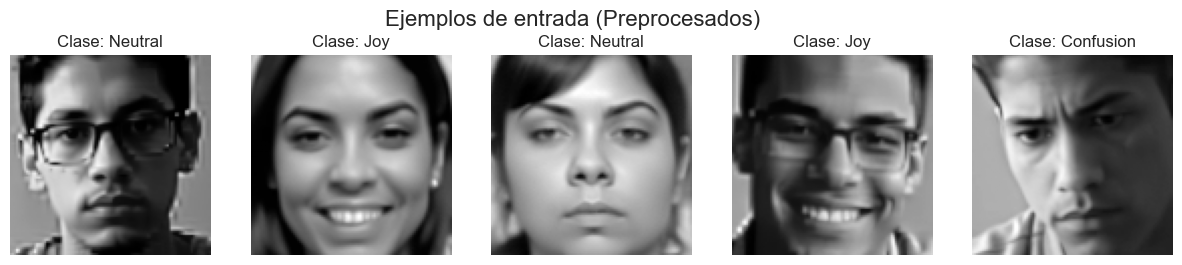

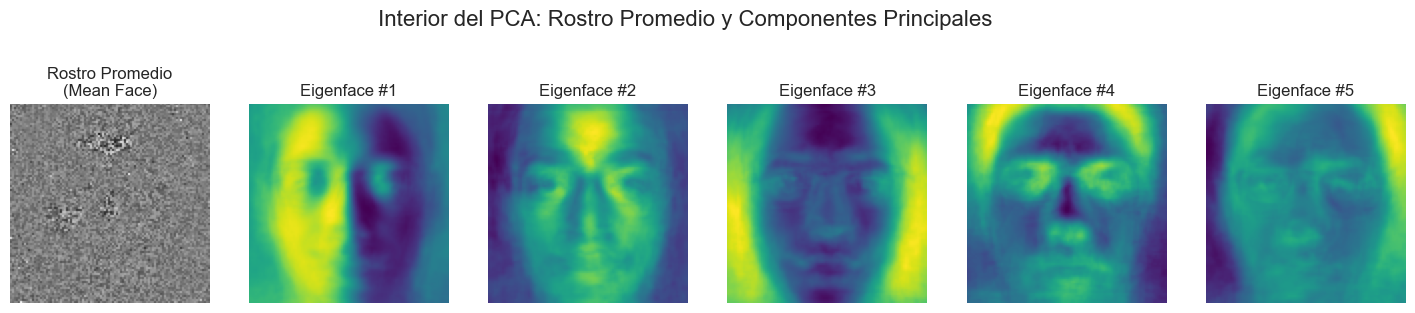

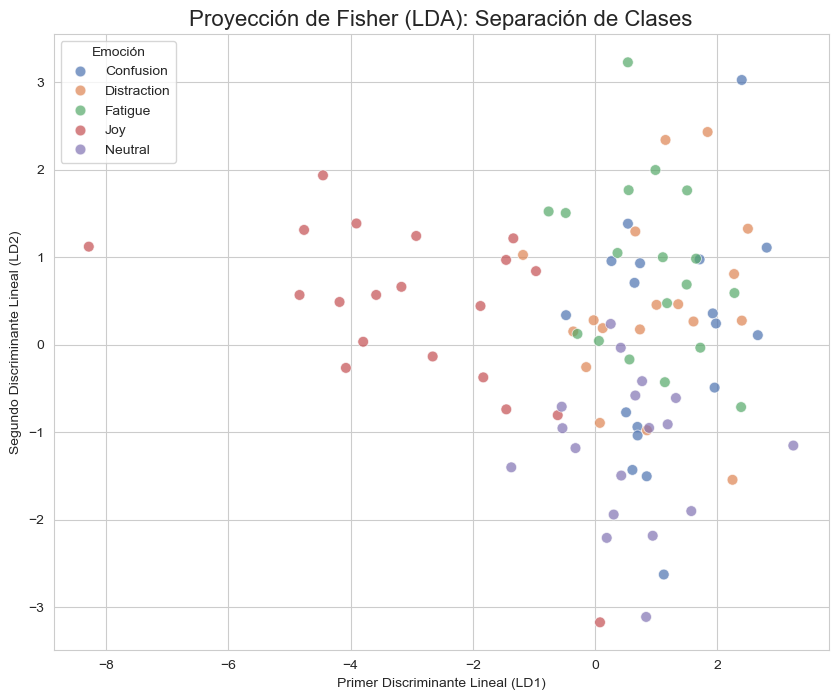

In [44]:
print("Generando gráficas del proceso...")

# 1. Ver ejemplos de datos
plot_samples(X_full_train, y_full_train)

# 2. Ver qué aprendió el PCA (Eigenfaces)
plot_eigenfaces(pca)

# 3. Ver cómo separa los grupos el LDA
plot_lda_space(lda, X_test_pca, y_test)

In [45]:
print(f"Número total de Eigenfaces encontradas: {pca.n_components_}")

Número total de Eigenfaces encontradas: 148


Generando promedios por clase...


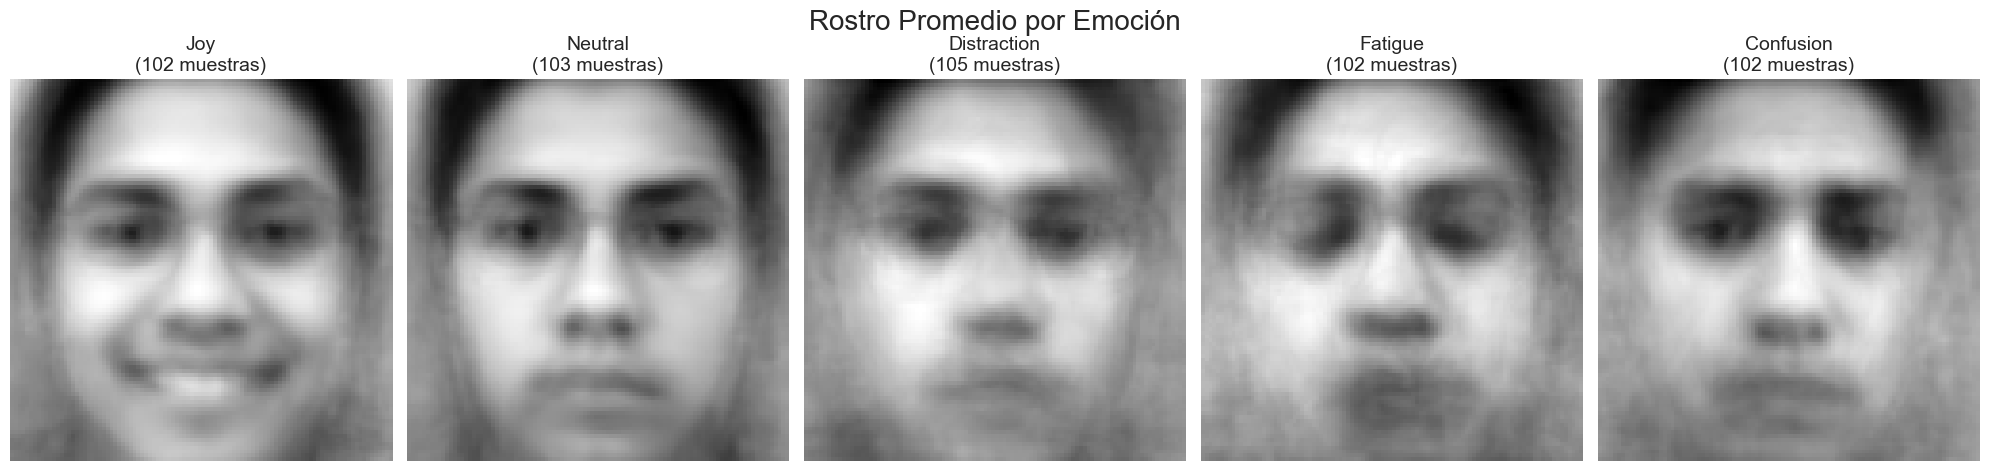

In [46]:
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]

def visualizar_rostros_promedio(X, y):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    print("Generando promedios por clase...")
    
    for i in range(5):
        #Filtramos todas las imágenes que pertenecen a la clase 'i'
        indices_clase = np.where(y == i)[0]
        imagenes_clase = X[indices_clase]
        
        if len(imagenes_clase) > 0:
            #Calculamos el promedio a lo largo del eje 0
            imagen_promedio = np.mean(imagenes_clase, axis=0)
            
            img_visual = imagen_promedio.reshape(100, 100)
            
            axes[i].imshow(img_visual, cmap='gray')
            axes[i].set_title(f"{nombres_clases[i]}\n({len(imagenes_clase)} muestras)", fontsize=14)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "Sin datos", ha='center')
            axes[i].axis('off')

    plt.suptitle("Rostro Promedio por Emoción", fontsize=20)
    plt.tight_layout()
    plt.show()

visualizar_rostros_promedio(X_full_train, y_full_train)

## Evaluación del test sintético

In [47]:
y_pred = lda.predict(X_test_pca)

# Métricas Globales
acc = accuracy_score(y_test, y_pred)
print(f"ACCURACY GLOBAL: {acc:.4f}")

# Reporte detallado por clase (Precision, Recall, F1)
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=nombres_clases))

ACCURACY GLOBAL: 0.5978

Reporte de Clasificación:
              precision    recall  f1-score   support

         Joy       1.00      0.80      0.89        20
     Neutral       0.54      0.72      0.62        18
 Distraction       0.52      0.61      0.56        18
     Fatigue       0.50      0.33      0.40        18
   Confusion       0.47      0.50      0.49        18

    accuracy                           0.60        92
   macro avg       0.61      0.59      0.59        92
weighted avg       0.62      0.60      0.60        92



### Matriz de confusión

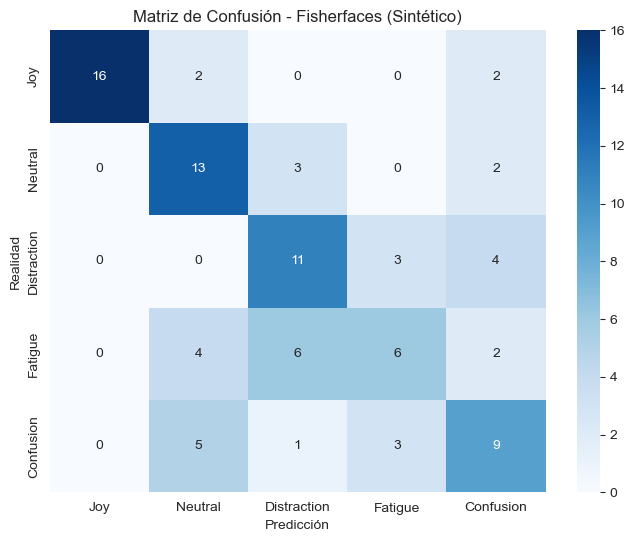

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Fisherfaces (Sintético)')
plt.show()

## Evaluación Sintética Fisherfaces

Análisis de tus Resultados (Fisherfaces Mejorado)
1. Joy tiene una precisión: 1.00 (Perfecta)

Esto es muy positivo. Al recortar la cara, la característica de "dientes mostrándose" y "comisuras hacia arriba" se volvió matemáticamente inconfundible para el algoritmo LDA frente a las otras 4 emociones neutras.

2. Fatigue vs. Distraction

Solo acertó 6 veces.
Confundió 6 veces Fatiga con Distraction.
Confundió 4 veces Fatiga con Neutral.


El modelo presenta dificultades para distinguir la 'Fatiga'. Matemáticamente, un rostro cansado (párpados caídos) tiene una varianza de píxeles muy similar a un rostro distraído o neutral. A diferencia de 'Joy', la fatiga no introduce cambios geométricos drásticos de alto contraste, lo que dificulta la separación lineal que intenta Fisherfaces.